# Verify DepthSplat Torch Files

This notebook verifies rendered scenes from .torch chunk files by:
- Loading torch chunk files from the output directory
- Selecting random scenes
- Visualizing all passes (RGB, Depth, Mask) for selected views
- Showing camera parameters and metadata

In [1]:
import os
import json
import random
from pathlib import Path
from io import BytesIO
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

## Configuration

In [2]:
# Define the output directory containing .torch files
torch_dir = Path("./debug")
# torch_dir = Path.home() / ".objaverse" / "depthsplat"

# Find all .torch files in train and test directories
torch_files = list(torch_dir.rglob("*.torch"))

print(f"Found {len(torch_files)} .torch files in {torch_dir}")
for f in torch_files:
    print(f"  - {f.relative_to(torch_dir)}")

Found 3 .torch files in debug
  - test/000000.torch
  - train/000001.torch
  - train/000000.torch


## Helper Functions

In [3]:
def tensor_to_image(tensor: torch.Tensor) -> np.ndarray:
    """
    Convert a tensor containing compressed PNG bytes back to an image.
    
    Args:
        tensor: Tensor of uint8 bytes representing a PNG image
    
    Returns:
        numpy array of the decoded image
    """
    # Convert tensor to bytes
    img_bytes = tensor.numpy().tobytes()
    # Load as PIL image
    img = Image.open(BytesIO(img_bytes))
    return np.array(img)


def load_scenes_from_torch(torch_path: Path) -> list:
    """
    Load all scenes from a .torch file.
    
    Args:
        torch_path: Path to the .torch file
    
    Returns:
        List of scene dictionaries
    """
    return torch.load(torch_path, weights_only=False)


def display_scene(scene: dict, num_views: int = 4):
    """
    Display a scene with its views.
    
    Args:
        scene: Scene dictionary from .torch file
        num_views: Number of views to display
    """
    key = scene.get('key', 'Unknown')
    cameras = scene.get('cameras')  # [N, 18] tensor
    images = scene.get('images')    # List of tensors (compressed PNG bytes)
    depths = scene.get('depths')    # [N, H, W] tensor or None
    masks = scene.get('masks')      # [N, H, W] tensor or None
    
    print("=" * 80)
    print(f"Scene Key: {key}")
    print("=" * 80)
    
    if cameras is not None:
        print(f"Number of views: {cameras.shape[0]}")
        print(f"Camera tensor shape: {cameras.shape}")
    
    if images:
        print(f"Number of images: {len(images)}")
    
    if depths is not None:
        print(f"Depth tensor shape: {depths.shape}")
    
    if masks is not None:
        print(f"Mask tensor shape: {masks.shape}")
    
    # Show normalization info if available
    if 'normalization' in scene:
        norm = scene['normalization']
        print(f"\nNormalization:")
        print(f"  Scale: {norm.get('scale', 'N/A')}")
        print(f"  Bounding sphere radius: {norm.get('bounding_sphere_radius', 'N/A')}")
    
    # Select random views to display
    total_views = len(images) if images else 0
    if total_views == 0:
        print("No images found in scene!")
        return
    
    view_indices = random.sample(range(total_views), min(num_views, total_views))
    
    # Determine number of columns based on available data
    has_depth = depths is not None
    has_mask = masks is not None
    num_cols = 1 + int(has_depth) + int(has_mask)
    
    fig, axes = plt.subplots(len(view_indices), num_cols, 
                             figsize=(4 * num_cols, 4 * len(view_indices)))
    
    if len(view_indices) == 1:
        axes = axes.reshape(1, -1)
    if num_cols == 1:
        axes = axes.reshape(-1, 1)
    
    for row, view_idx in enumerate(view_indices):
        col = 0
        
        # RGB Image
        ax = axes[row, col]
        img = tensor_to_image(images[view_idx])
        ax.imshow(img)
        ax.set_title(f"View {view_idx} - RGB")
        ax.axis('off')
        col += 1
        
        # Depth
        if has_depth:
            ax = axes[row, col]
            depth = depths[view_idx].numpy()
            
            # Handle invalid depth values (marked as -1)
            valid_mask = depth > 0
            depth_vis = depth.copy()
            depth_vis[~valid_mask] = np.nan
            
            # Get valid range for colormap
            valid_depths = depth_vis[~np.isnan(depth_vis)]
            if len(valid_depths) > 0:
                vmin = np.percentile(valid_depths, 1)
                vmax = np.percentile(valid_depths, 99)
            else:
                vmin, vmax = 0, 1
            
            im = ax.imshow(depth_vis, cmap='inferno', vmin=vmin, vmax=vmax)
            ax.set_title(f"View {view_idx} - Depth")
            ax.axis('off')
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            col += 1
        
        # Mask
        if has_mask:
            ax = axes[row, col]
            mask = masks[view_idx].numpy()
            ax.imshow(mask, cmap='gray', vmin=0, vmax=1)
            ax.set_title(f"View {view_idx} - Mask")
            ax.axis('off')
            col += 1
    
    plt.tight_layout()
    plt.show()
    
    # Display camera info for first selected view
    if cameras is not None:
        view_idx = view_indices[0]
        cam = cameras[view_idx].numpy()
        print(f"\nCamera parameters for view {view_idx}:")
        print(f"  fx (normalized): {cam[0]:.4f}")
        print(f"  fy (normalized): {cam[1]:.4f}")
        print(f"  cx (normalized): {cam[2]:.4f}")
        print(f"  cy (normalized): {cam[3]:.4f}")
        print(f"  w2c matrix (3x4):")
        w2c = cam[6:18].reshape(3, 4)
        for i in range(3):
            print(f"    [{w2c[i, 0]:7.4f}, {w2c[i, 1]:7.4f}, {w2c[i, 2]:7.4f}, {w2c[i, 3]:7.4f}]")

## Load and Verify Scenes

In [4]:
# Load all scenes from all torch files
all_scenes = []
for torch_file in torch_files:
    try:
        scenes = load_scenes_from_torch(torch_file)
        print(f"Loaded {len(scenes)} scenes from {torch_file.name}")
        all_scenes.extend(scenes)
    except Exception as e:
        print(f"Error loading {torch_file}: {e}")

print(f"\nTotal scenes loaded: {len(all_scenes)}")

Loaded 1 scenes from 000000.torch
Loaded 2 scenes from 000001.torch
Loaded 2 scenes from 000000.torch

Total scenes loaded: 5


Verifying 3 random scenes...

Scene Key: 00089a40101d4c1487edf050b94f6008
Number of views: 20
Camera tensor shape: torch.Size([20, 18])
Number of images: 20
Depth tensor shape: torch.Size([20, 256, 256])
Mask tensor shape: torch.Size([20, 256, 256])

Normalization:
  Scale: 3.464474723361321
  Bounding sphere radius: 0.6257847329851202


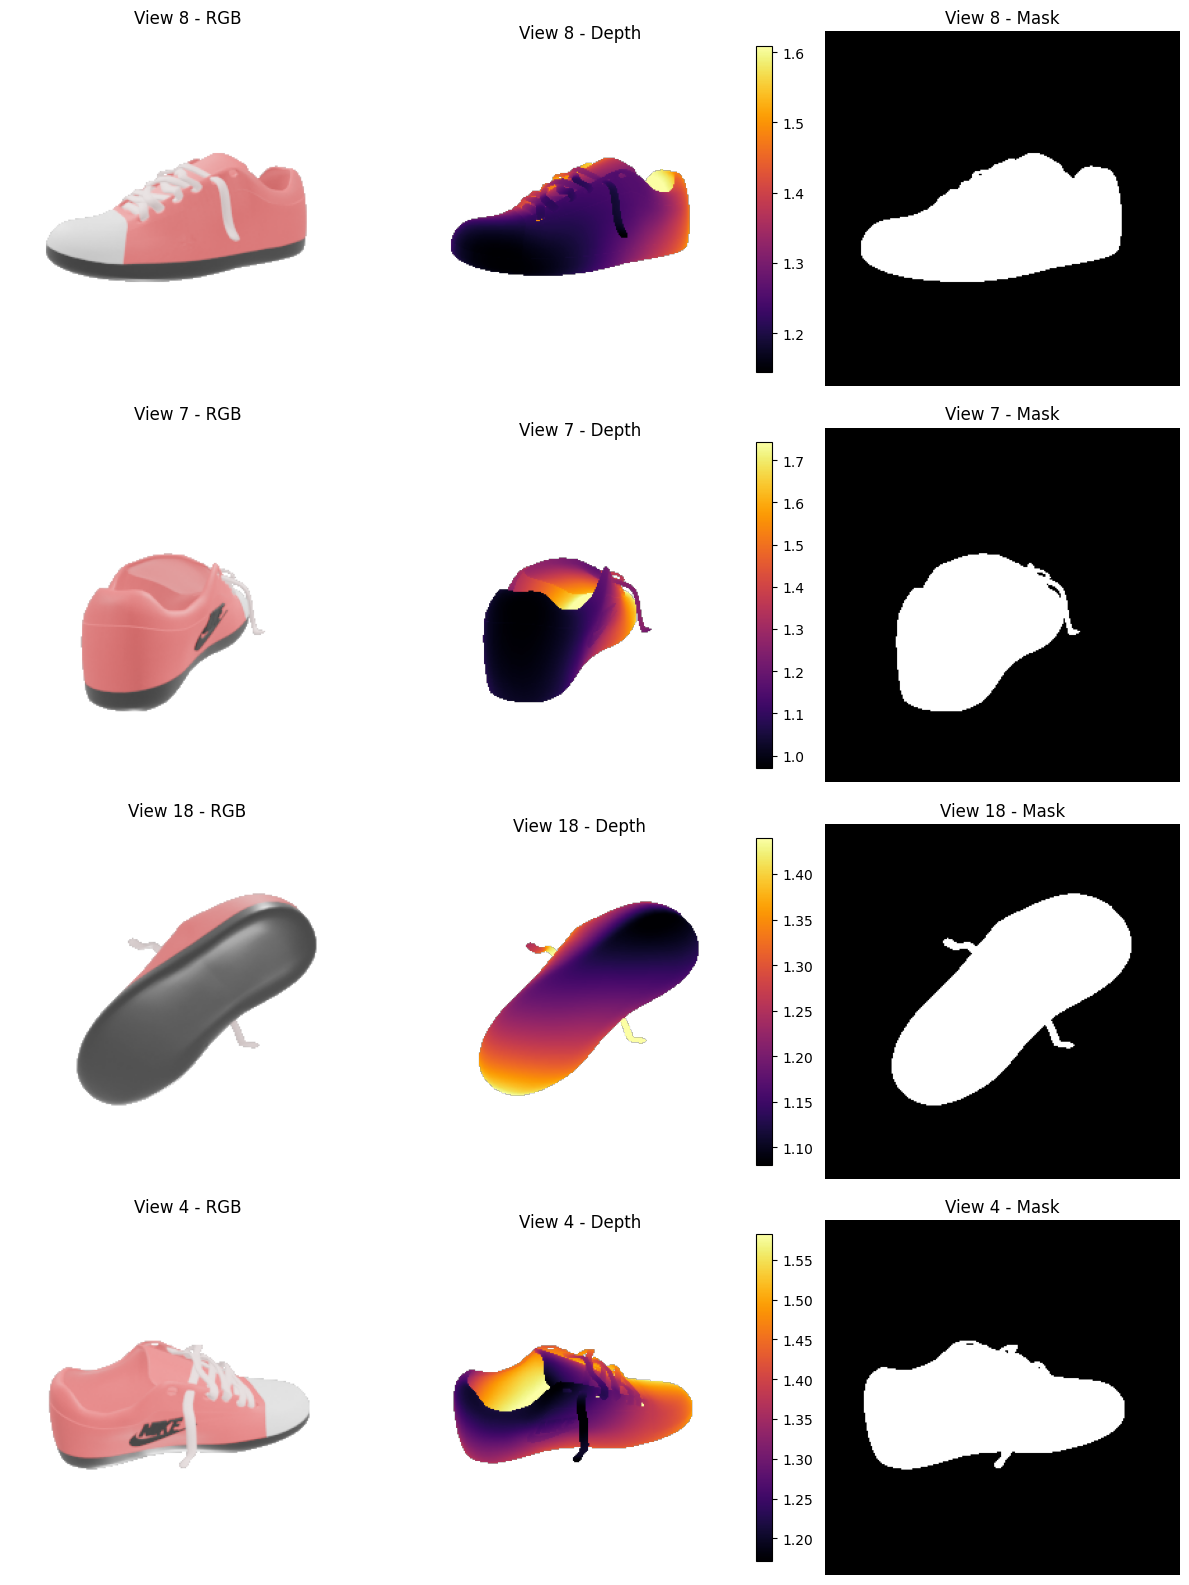


Camera parameters for view 8:
  fx (normalized): 1.0723
  fy (normalized): 1.0723
  cx (normalized): 0.5000
  cy (normalized): 0.5000
  w2c matrix (3x4):
    [ 0.3430,  0.9393, -0.0000,  0.0000]
    [ 0.1483, -0.0542, -0.9875, -0.0000]
    [-0.9275,  0.3387, -0.1579,  1.4126]

Scene Key: 000b662130de4537ad8a233c58b0b4fe
Number of views: 20
Camera tensor shape: torch.Size([20, 18])
Number of images: 20
Depth tensor shape: torch.Size([20, 256, 256])
Mask tensor shape: torch.Size([20, 256, 256])

Normalization:
  Scale: 0.02137027915122792
  Bounding sphere radius: 0.6907873764901068


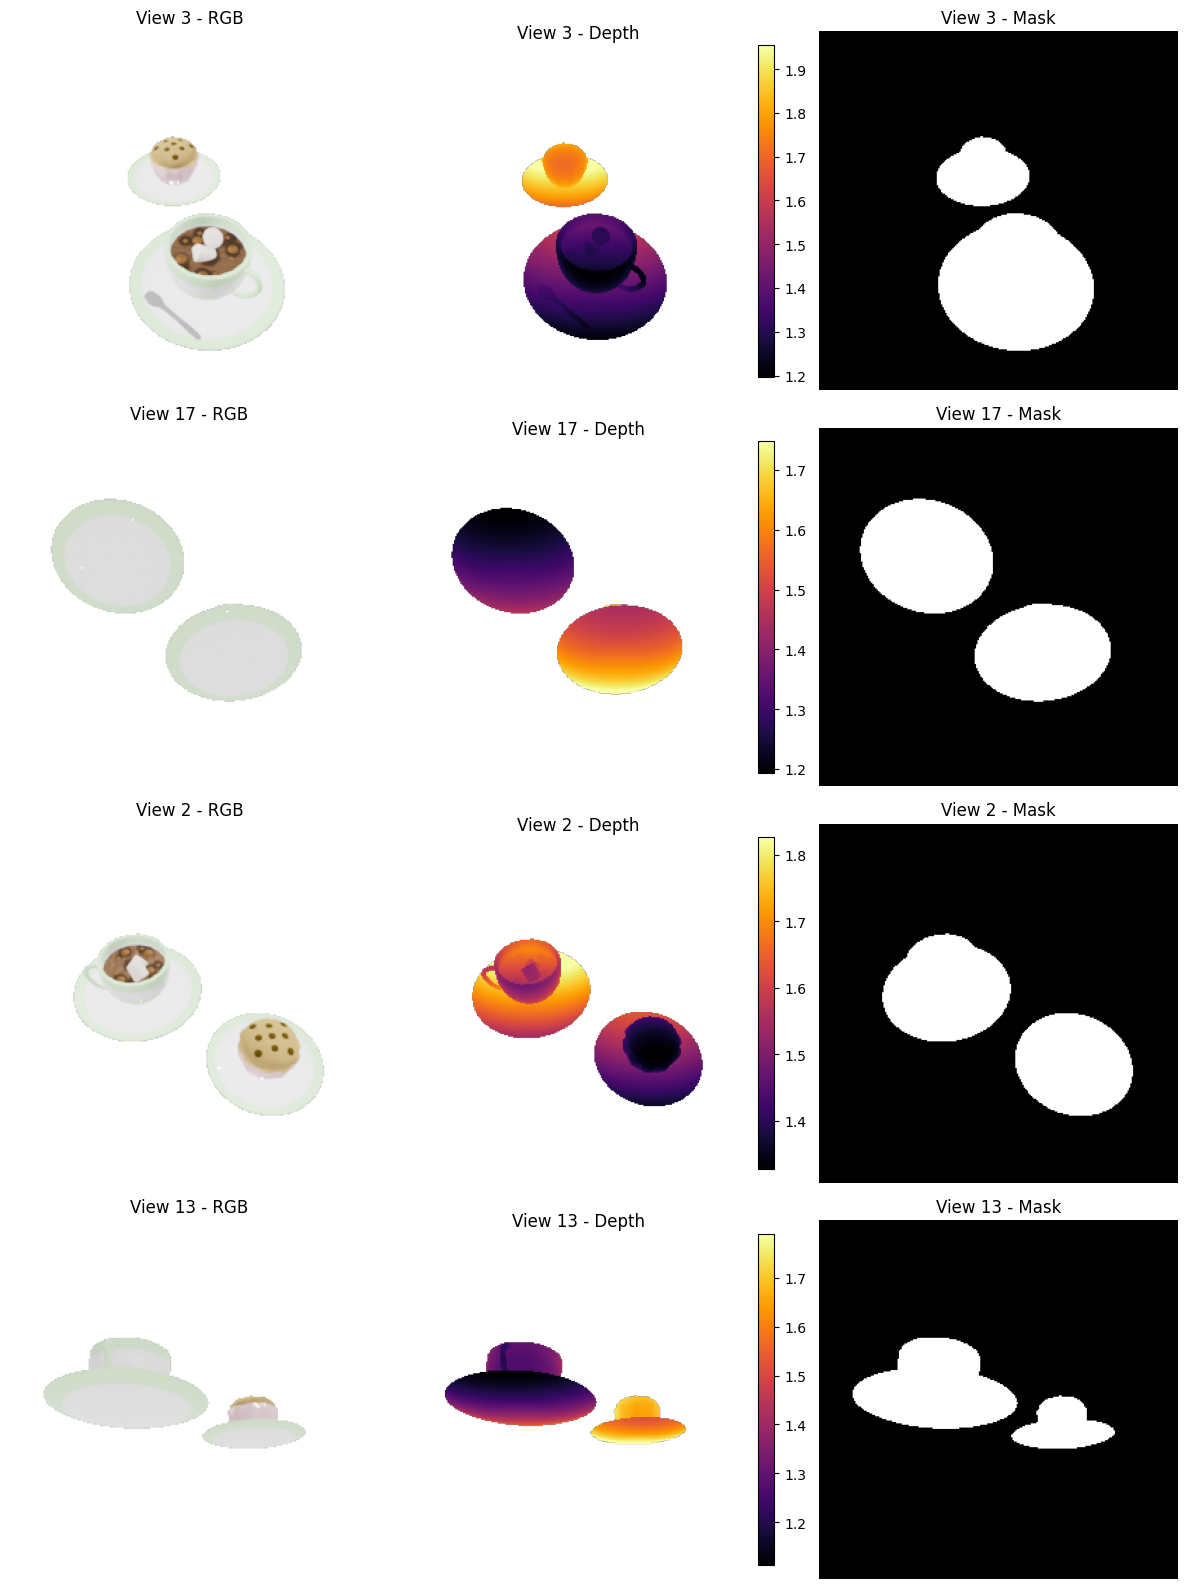


Camera parameters for view 3:
  fx (normalized): 1.0723
  fy (normalized): 1.0723
  cx (normalized): 0.5000
  cy (normalized): 0.5000
  w2c matrix (3x4):
    [ 0.7936,  0.6084,  0.0000,  0.0000]
    [ 0.4163, -0.5430, -0.7293, -0.0000]
    [-0.4437,  0.5788, -0.6842,  1.5594]

Scene Key: 001337c586f34fe7b3c7948d577229a3
Number of views: 20
Camera tensor shape: torch.Size([20, 18])
Number of images: 20
Depth tensor shape: torch.Size([20, 256, 256])
Mask tensor shape: torch.Size([20, 256, 256])

Normalization:
  Scale: 0.20928361532846962
  Bounding sphere radius: 0.6814069648026897


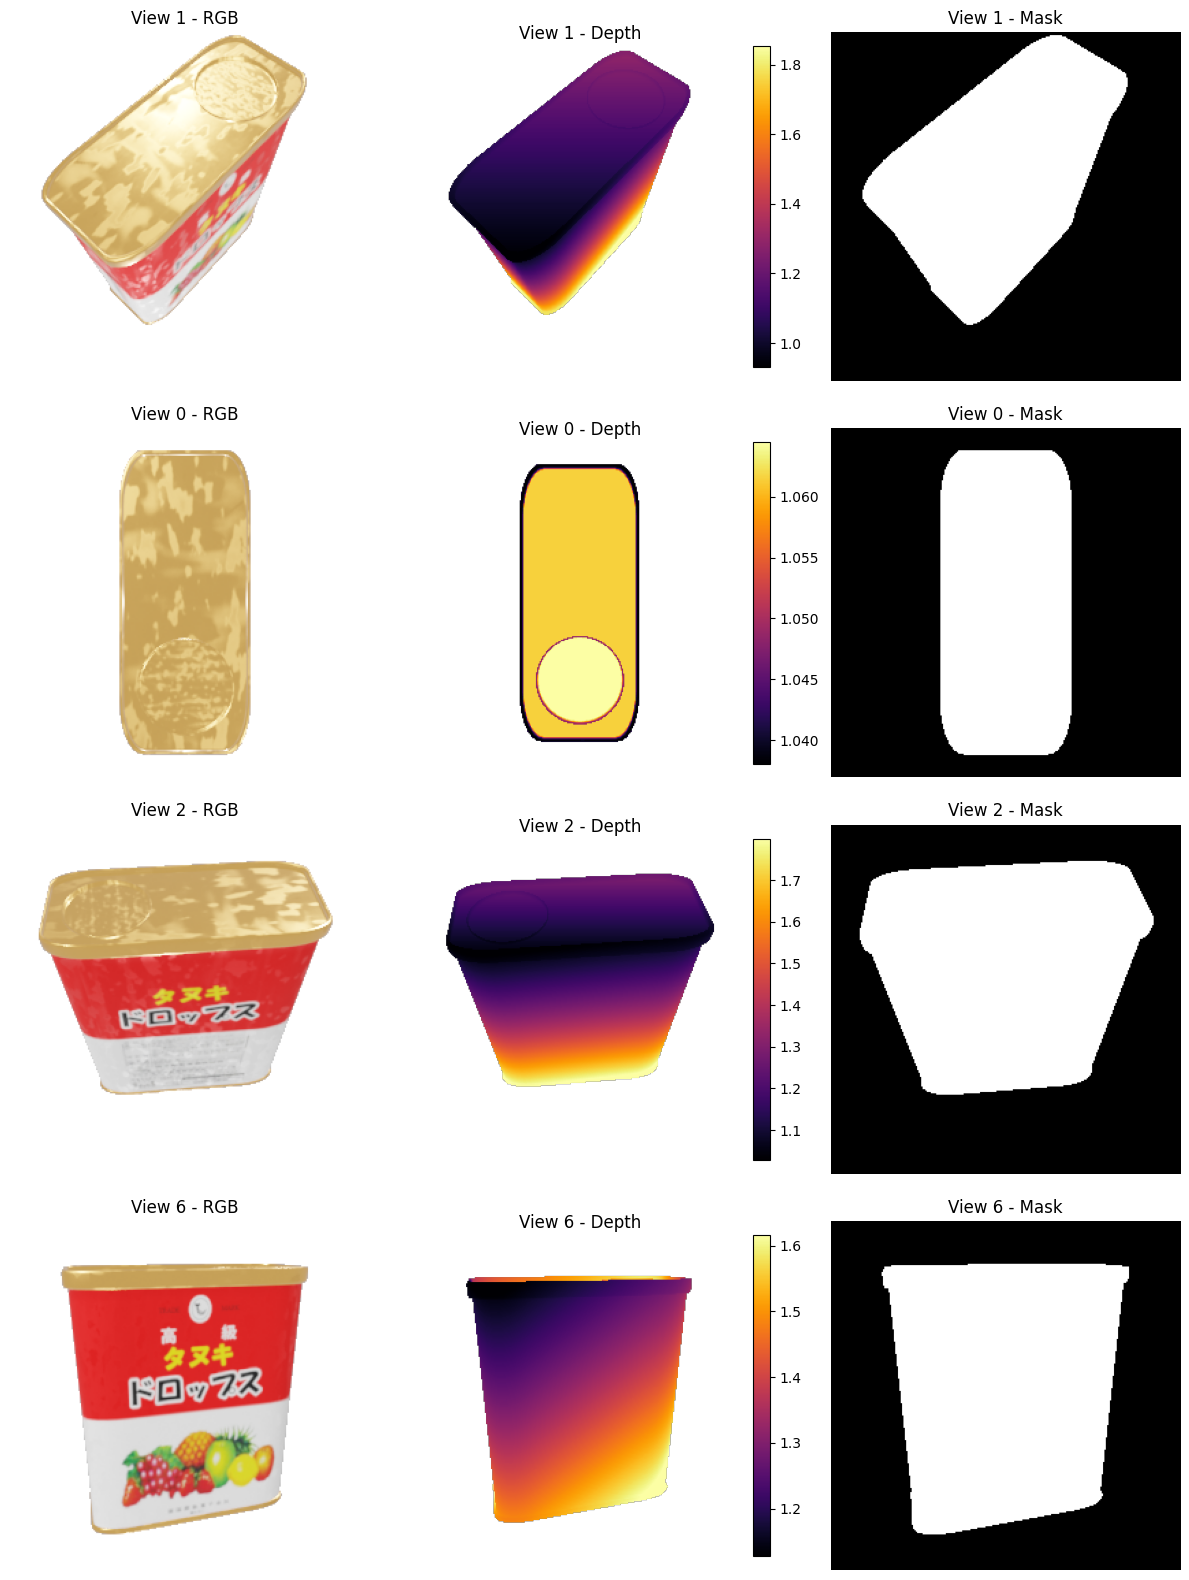


Camera parameters for view 1:
  fx (normalized): 1.0723
  fy (normalized): 1.0723
  cx (normalized): 0.5000
  cy (normalized): 0.5000
  w2c matrix (3x4):
    [ 0.6755, -0.7374,  0.0000, -0.0000]
    [-0.6598, -0.6044, -0.4466, -0.0000]
    [ 0.3293,  0.3017, -0.8947,  1.5382]



In [5]:
# Verify random scenes
num_to_verify = min(3, len(all_scenes))
selected_scenes = random.sample(all_scenes, num_to_verify)

print(f"Verifying {num_to_verify} random scenes...\n")

for scene in selected_scenes:
    try:
        display_scene(scene, num_views=4)
    except Exception as e:
        print(f"Error displaying scene {scene.get('key', 'Unknown')}: {e}")
        import traceback
        traceback.print_exc()
    print()

## Summary Statistics

In [6]:
print("Collecting statistics from all scenes...")
print("=" * 80)

total_views = 0
scenes_with_depth = 0
scenes_with_mask = 0
depth_stats = []

for scene in all_scenes:
    images = scene.get('images', [])
    total_views += len(images)
    
    if scene.get('depths') is not None:
        scenes_with_depth += 1
        # Get depth statistics for valid pixels
        depths = scene['depths'].numpy()
        valid_depths = depths[depths > 0]
        if len(valid_depths) > 0:
            depth_stats.append({
                'min': valid_depths.min(),
                'max': valid_depths.max(),
                'mean': valid_depths.mean()
            })
    
    if scene.get('masks') is not None:
        scenes_with_mask += 1

print(f"Total scenes: {len(all_scenes)}")
print(f"Total views: {total_views}")
print(f"Average views per scene: {total_views / len(all_scenes):.1f}" if all_scenes else "N/A")
print(f"\nScenes with depth: {scenes_with_depth} ({100*scenes_with_depth/len(all_scenes):.1f}%)" if all_scenes else "N/A")
print(f"Scenes with mask: {scenes_with_mask} ({100*scenes_with_mask/len(all_scenes):.1f}%)" if all_scenes else "N/A")

if depth_stats:
    print(f"\nDepth statistics (valid pixels only):")
    print(f"  Min depth: {min(d['min'] for d in depth_stats):.3f}")
    print(f"  Max depth: {max(d['max'] for d in depth_stats):.3f}")
    print(f"  Mean depth: {np.mean([d['mean'] for d in depth_stats]):.3f}")

Total scenes: 5
Total views: 100
Average views per scene: 20.0

Scenes with depth: 5 (100.0%)
Scenes with mask: 5 (100.0%)

Depth statistics (valid pixels only):
  Min depth: 0.731
  Max depth: 2.176
  Mean depth: 1.314


## Check Index Files

In [7]:
# Check index.json files
for stage in ['train', 'test']:
    index_path = torch_dir / stage / 'index.json'
    if index_path.exists():
        with open(index_path, 'r') as f:
            index = json.load(f)
        print(f"\n{stage.upper()} index:")
        print(f"  Total scenes indexed: {len(index)}")
        print(f"  Sample keys: {list(index.keys())[:5]}")
    else:
        print(f"\n{stage.upper()} index: Not found")

# Check conversion config
config_path = torch_dir / 'conversion_config.json'
if config_path.exists():
    with open(config_path, 'r') as f:
        config = json.load(f)
    print(f"\nConversion config:")
    for key, value in config.items():
        print(f"  {key}: {value}")


TRAIN index:
  Total scenes indexed: 4
  Sample keys: ['0011b0e07fde4491b1f3875f25fff2d7', '000b662130de4537ad8a233c58b0b4fe', '000d386e0bc64a13b93bd18aebdee016', '001337c586f34fe7b3c7948d577229a3']

TEST index:
  Total scenes indexed: 1
  Sample keys: ['00089a40101d4c1487edf050b94f6008']

Conversion config:
  output_dir: debug
  train_split: 0.9
  scenes_per_chunk: 2
  image_size: [256, 256]
  include_depth: True
  include_mask: True
  include_normal: True
  num_views: 20
  total_scenes: 5
  train_scenes: 4
  test_scenes: 1
  train_failed: 0
  test_failed: 0
